In [1]:
!gdown https://drive.google.com/uc?id=1K4APdA6GUhS57kS6YGMYIU8QhFMHSDLd
!unzip -q ModMonuSeg.zip

Downloading...
From: https://drive.google.com/uc?id=1K4APdA6GUhS57kS6YGMYIU8QhFMHSDLd
To: /content/ModMonuSeg.zip
224MB [00:02, 76.7MB/s]
replace ModMonuSeg/Test/GroundTruth/TCGA-2Z-A9J9-01A-01-TS1_bin_mask-PCH0.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [0]:
from ConfigFile import Config
from Unet import Unet
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
get_ipython().run_line_magic('matplotlib', 'inline')

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.layers import Lambda, RepeatVector, Reshape
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split

In [10]:
config = Config()
unet_instance = Unet()
X, y = unet_instance.load_Images(config.train_parent_dir, (config.im_width, config.im_height),config.img_folder, config.gt_folder, config.train_gt_extension)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

No. of images =  1080


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [0]:
input_image = Input((None, None, 3), name='img')
model = unet_instance.buildUnet_Architecture(input_image, n_filters=18, dropout=0.06, batchnorm=True)
model.compile(optimizer=config.optimizer, loss="binary_crossentropy", metrics=["accuracy", unet_instance.dice_coefficient, unet_instance.f1_score])

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 1 504         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 1 72          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 1 0           batch_normalization_1[0][0]      
______________________________________________________________________________________________

#Start training the model

In [13]:
history = model.fit(X_train, y_train, batch_size=config.batch_size, epochs=config.epochs, callbacks=config.callbacks,
                    validation_data=(X_valid, y_valid))

Epoch 1/100
16/16 [==============================] - ETA: 0s - loss: 0.7697 - accuracy: 0.5838 - dice_coefficient: 0.4939 - f1_score: 0.5728
Epoch 00001: val_loss improved from inf to 0.58872, saving model to unet-model.h5
16/16 [==============================] - 7s 418ms/step - loss: 0.7697 - accuracy: 0.5838 - dice_coefficient: 0.4939 - f1_score: 0.5728 - val_loss: 0.5887 - val_accuracy: 0.7306 - val_dice_coefficient: 0.3569 - val_f1_score: 0.0590 - lr: 0.0010
Epoch 2/100
16/16 [==============================] - ETA: 0s - loss: 0.5325 - accuracy: 0.8463 - dice_coefficient: 0.5280 - f1_score: 0.7400
Epoch 00002: val_loss improved from 0.58872 to 0.56414, saving model to unet-model.h5
16/16 [==============================] - 5s 328ms/step - loss: 0.5325 - accuracy: 0.8463 - dice_coefficient: 0.5280 - f1_score: 0.7400 - val_loss: 0.5641 - val_accuracy: 0.7465 - val_dice_coefficient: 0.3684 - val_f1_score: 0.1510 - lr: 0.0010
Epoch 3/100
16/16 [==============================] - ETA: 0s -

##Learning Curve Plot 

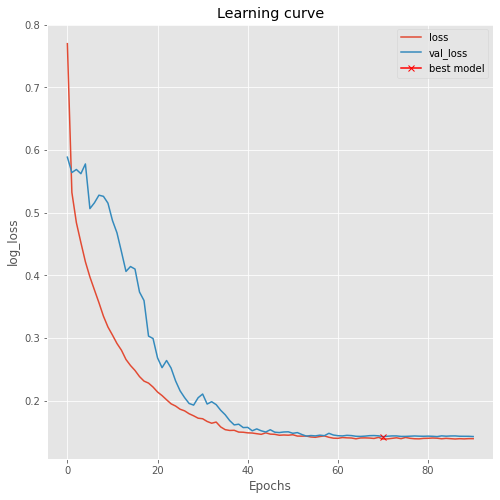

In [14]:
unet_instance.curve_plot(history)

In [16]:
X_test, y_test = unet_instance.load_Images(config.test_parent_dir, (config.im_width, config.im_height),
                  config.img_folder, config.gt_folder, config.test_gt_extension)
model.evaluate(X_test, y_test, verbose=1)

No. of images =  504


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '



16/16 [==============================] - 1s 72ms/step - loss: 0.2514 - accuracy: 0.9034 - dice_coefficient: 0.7215 - f1_score: 0.7728


[0.2514133155345917, 0.9034344553947449, 0.7214778661727905, 0.772824764251709]

# Predict on train, val and test

In [17]:
preds = model.predict(X_test, verbose=1)
preds_t = (preds > 0.5).astype(np.uint8)

16/16 [==============================] - 1s 56ms/step


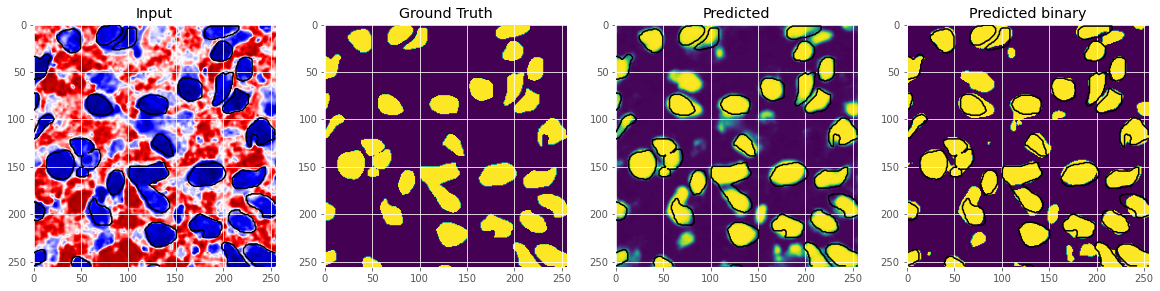

In [18]:
# Check if training data looks all right
unet_instance.plot_sample(X_test, y_test, preds, preds_t)

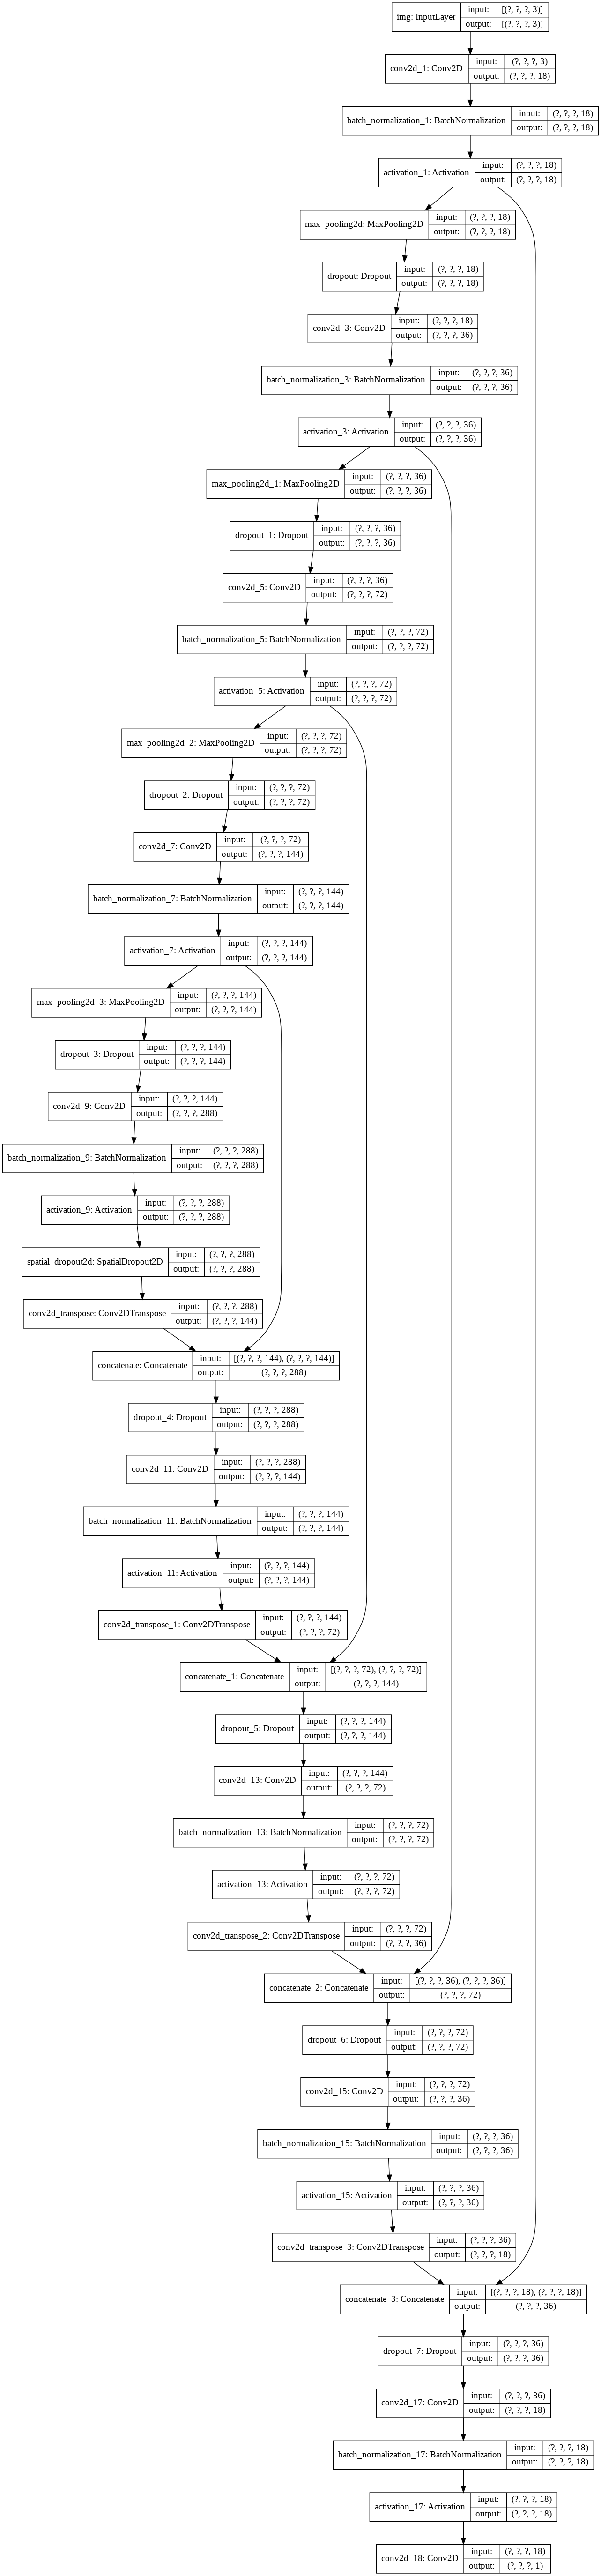

In [19]:
from tensorflow.keras.utils import plot_model
# Plot model graph
plot_model(model, show_shapes=True, show_layer_names=True, to_file='unetModel.png')
from IPython.display import Image
Image(retina=True, filename='unetModel.png')